# Doppler shifts
Exploring doppler shift on precision and quality. Specifically in the K-band

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import PyAstronomy.pyasl as pyasl
import astropy.constants as const

import eniric
#eniric.cache["location"] = None  # Disable caching for these tests
eniric.cache["location"] = ".joblib"  # Enable caching

from eniric.broaden import rotational_convolution, resolution_convolution
from eniric.utilities import band_limits, load_aces_spectrum, wav_selector
from eniric_scripts.phoenix_precision import convolve_and_resample 
from eniric.snr_normalization import snr_constant_band
from eniric.Qcalculator import rv_precision, quality
from eniric.utilities import doppler_shift_wav, doppler_shift_flux
from eniric.atmosphere import Atmosphere


/home/jneal/anaconda3/envs/eniric/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Convolution settings
epsilon = 0.6
vsini = 10.0
R = 40000

In [3]:
wav1, flux1 = load_aces_spectrum([3900, 4.5, 0.0, 0])


/home/jneal/anaconda3/envs/eniric/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
kmin_, kmax_ = band_limits("K")
# To avoid the strong telluric band limititations will shrink limits
span = kmax_ - kmin_
kmin_ = kmin_ + 0.1*span
kmax_ = kmax_ - 0.1*span

from eniric.utilities import doppler_limits
# doppler resilient boundraries
rvmax = 10000 # km/s 
kmin_dop, kmax_dop = doppler_limits(rvmax, kmin_, kmax_)

wav1, flux1 = wav_selector(wav1, flux1, kmin_dop, kmax_dop)


In [5]:
# PyAstronomy requires even spaced wavelength (eniric does not)
wav = np.linspace(wav1[0], wav1[-1], len(wav1))

flux = np.interp(wav, wav1, flux1)

In [6]:
# Normalization
const = snr_constant_band(wav, flux, snr=100, band="K")
flux = flux / const


	Sanity Check: The reference S/N at 2.21 was of 117439.59.


In [7]:
atm__ = Atmosphere.from_file(atmmodel="../../data/atmmodel/Average_TAPAS_2014.txt")


In [8]:
atm_ = atm__.copy()
atm_.wave_select(kmin_dop, kmax_dop)
atm_.mask_transmission(depth=2)
#atm_.bary_shift_mask(30,consecutive_test=False)
atm_2 = atm_.copy()
atm_.wave_select(kmin_dop, kmax_dop)

def qfunc(wav, flux):
    # Func to calculate the 4 precision versions
    atm = atm_.at(wav)
    rva = rv_precision(wav, flux)
    rvb = rv_precision(wav, flux, mask=atm.mask)
    rvc = rv_precision(wav, flux, mask=atm.transmission**2)
    q = quality(wav, flux)
    return rva, rvb, rvc, q

In [9]:
shifts = np.arange(-200, 200, 1)
#shifts = [1000]
rv1s, rv2s, rv3s, qs = [], [], [], []
nwav, _ = wav_selector(wav, flux, kmin_, kmax_)

for shift in tqdm(shifts):
    nflux = doppler_shift_flux(wav, flux, shift, new_wav=nwav)
    a,b,c,d = qfunc(nwav, nflux)
    rv1s.append(a.value)
    rv2s.append(b.value) 
    rv3s.append(c.value)    
    qs.append(d)
    

100%|██████████| 400/400 [00:04<00:00, 89.04it/s]


In [10]:
# rv2 with bary shifted mask

In [11]:
atm_2.bary_shift_mask(30,consecutive_test=False)

def qfunc2(wav, flux):
    # Func to calculate the 4 precision versions
    atm = atm_2.at(wav)
    rvb = rv_precision(wav, flux, mask=atm.mask)
    return rvb

rv2s_bary = []

for shift in tqdm(shifts):
    nflux = doppler_shift_flux(wav, flux, shift, new_wav=nwav)
    b2 = qfunc2(nwav, nflux)
    rv2s_bary.append(b2.value) 
    

100%|██████████| 400/400 [00:02<00:00, 178.71it/s]


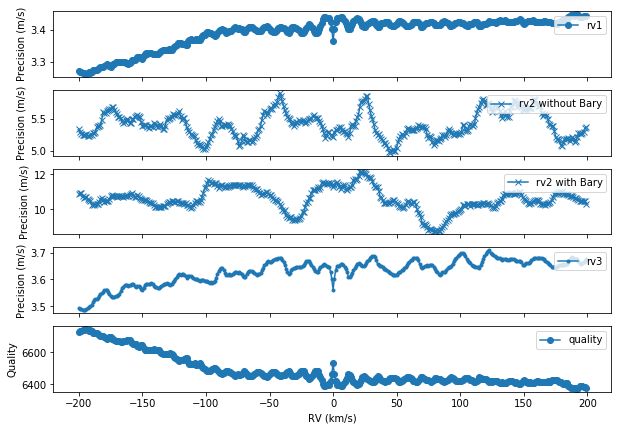

In [12]:
fig, axs = plt.subplots(5, 1, sharex=True, figsize=(10, 7))
axs[0].plot(shifts, rv1s, "o-", label="rv1")
axs[0].legend(loc=1)
axs[0].set_ylabel("Precision (m/s)")

axs[1].plot(shifts, rv2s, "x-", label="rv2 without Bary")
axs[1].legend(loc=1)
axs[1].set_ylabel("Precision (m/s)")

axs[2].plot(shifts, rv2s_bary, "x-", label="rv2 with Bary")
axs[2].legend(loc=1)
axs[2].set_ylabel("Precision (m/s)")

axs[3].plot(shifts, rv3s, ".-", label="rv3")
axs[3].legend(loc=1)
axs[3].set_ylabel("Precision (m/s)")

axs[4].plot(shifts, qs, "o-", label="quality")
axs[4].set_xlabel("RV (km/s)")
axs[4].set_ylabel("Quality")

plt.legend()
plt.show()
    

Applying doppler shifts of $+/- 200$ km/s only produce changes of $< \pm0.1$ m/s for conditions 1 and 3, and $\pm 2$ m/s for condition 2.

There is a slight slope due to the shape of the input spectrum.


In [13]:
atm_spec = atm_.at(wav)
sum1, len1 =   np.sum(atm_spec.mask), len(atm_spec.mask)
atm_spec2 = atm_2.at(wav)  # With bary shift
sum2, len2 =   np.sum(atm_spec2.mask), len(atm_spec2.mask)

print("Telluric mask: {0:d}/{1:d} = {2:.03}%".format(
    sum1,len1, 100*sum1 / len1))
print("Mask with Bary shift:: {0:d}/{1:d} = {2:4.03}%".format(
    sum2,len2, 100*sum2 / len2))


Telluric mask: 38990/92859 = 42.0%
Mask with Bary shift:: 11256/92859 = 12.1%


Applying the telluric mask reduces the spectrum analyzed to 40%, This inclusion for barycentric shift reduces this to 12% of the original spectra so there is a large increase in RV error.

## Cross correlations

Between a synthetic spectrum and atmospheric model

In [14]:
from PyAstronomy.pyasl import crosscorrRV

In [15]:
# Cross correlation of spectra wth telluric mask
xwav = np.linspace(kmin_, kmax_, len(wav1))
xflux = np.interp(xwav, wav1, flux1)
#trans = atm_.at(xwav).transmission()
print(len(xwav), len(atm_.wl))

s, corr = crosscorrRV(xwav, xflux, atm_.wl, atm_.transmission, rvmin=-200, rvmax=200, drv=2, mode="doppler", skipedge=10000)

92859 5184211


In [16]:
# Cross correlation of spectra wth telluric mask
# PyAstronomy requires even spaced wavelength (eniric does not)
xwav = np.linspace(kmin_, kmax_, len(wav1))
xflux = np.interp(xwav, wav1, flux1)
atm2 = atm_.at(xwav)

s2, corr2 = crosscorrRV(atm2.wl, atm2.transmission, wav1, flux1, rvmin=-200, rvmax=200, drv=1, mode="doppler", skipedge=10000)

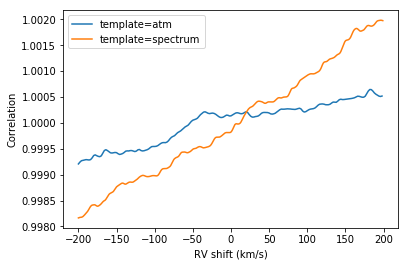

In [17]:
# Cross correlations
plt.plot(s,corr/np.mean(corr), label="template=atm")
plt.plot(s2,corr2/np.mean(corr2), label="template=spectrum")

plt.xlabel("RV shift (km/s)")
plt.ylabel("Correlation")
plt.legend()
plt.show()

In [18]:
# Auto Correletation

In [19]:
wavauto, corr_wav_auto = crosscorrRV( wav1, flux1, wav1, flux1, rvmin=-200, rvmax=200, drv=1, mode="doppler", skipedge=10000)

In [20]:
atmauto, corr_atm_auto = crosscorrRV(atm2.wl, atm2.transmission,atm2.wl, atm2.transmission, rvmin=-200, rvmax=200, drv=1, mode="doppler", skipedge=10000)

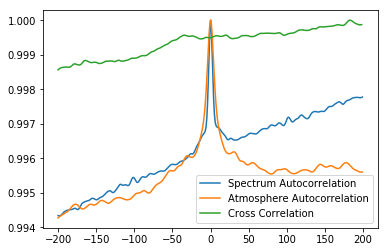

In [21]:
plt.plot(wavauto, corr_wav_auto/max(corr_wav_auto), label="Spectrum Autocorrelation")
plt.plot(atmauto, corr_atm_auto/max(corr_atm_auto), label="Atmosphere Autocorrelation")
plt.plot(s, corr/max(corr), label="Cross Correlation")
plt.legend()

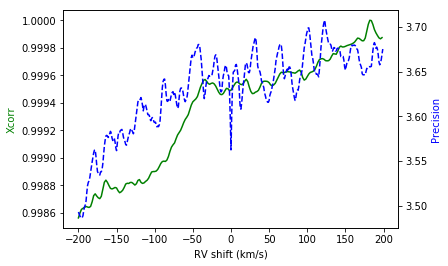

In [22]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(s,corr/np.max(corr),"g", label="xcorr")
ax2.plot(shifts, rv3s, "b--",label="RV3")

ax1.set_xlabel("RV shift (km/s)")
ax1.set_ylabel('Xcorr', color='g')
ax2.set_ylabel('Precision', color='b')
#plt.legend()
plt.show()